In [2]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


/Users/adikondepudi/miniforge3/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1670076285409/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


In [3]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("mps")

In [4]:
# reading data
df_features = pd.read_csv("./elliptic/elliptic_txs_features.csv", header=None)
df_classes= pd.read_csv("./elliptic/elliptic_txs_classes.csv")
df_edgelist = pd.read_csv("./elliptic/elliptic_txs_edgelist.csv")

In [5]:
df_classes.loc[df_classes['class'] == '1', 'class'] = "illicit"
df_classes.loc[df_classes['class'] == '2', 'class'] = "licit"

In [6]:
# renaming columns
df_features.columns = ["id", "time step"] + [f"local_feat_{i}" for i in range(93)] + [f"agg_feat_{i}" for i in range(72)]
df_classes.columns = ["id", "class"]
df_features.head()
df_classes.head()

,id,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,licit
4,230460314,unknown


In [7]:
# adding class data
df = pd.merge(df_features, df_classes, how="inner", on="id")
second_column = df.pop('class')
df.insert(1, 'class', second_column)
df.head()

,id,class,time step,local_feat_0,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,230425980,unknown,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,unknown,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,unknown,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,licit,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,unknown,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [8]:
df_licit_illicit = df[df["class"] != "unknown"]
df_licit_illicit.head()

,id,class,time step,local_feat_0,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
3,232438397,licit,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
9,232029206,licit,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
10,232344069,licit,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
11,27553029,licit,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
16,3881097,licit,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [9]:
y = df_licit_illicit.iloc[:, 0:2]
y = y.drop(["id"], axis=1).values
X = df_licit_illicit.drop(["class", "id", "time step"], axis=1).values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = y.ravel()
y = le.fit_transform(y)

In [10]:
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).long()

In [11]:
# Create a TensorDataset to hold the data
data = TensorDataset(X_tensor, y_tensor)

# Split the data into training and test sets
train_data, test_data = torch.utils.data.random_split(data, [int(0.8 * len(data)), len(data) - int(0.8 * len(data))])

# Create data loaders for the training and test sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [12]:
# Define the neural network
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=X.shape[1], out_features=64)
        self.fc2 = torch.nn.Linear(in_features=64, out_features=64)
        self.fc3 = torch.nn.Linear(in_features=64, out_features=len(set(y)))

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
import timeit
a_cpu = torch.rand(250, device='cpu')
b_cpu = torch.rand((250, 250), device='cpu')
a_mps = torch.rand(250, device='mps')
b_mps = torch.rand((250, 250), device='mps')

print('cpu', timeit.timeit(lambda: a_cpu @ b_cpu, number=100_000))
print('gpu', timeit.timeit(lambda: a_mps @ b_mps, number=100_000))

cpu 1.3819190000067465
gpu 17.970439917000476


In [14]:
# Create an instance of the network
net = Net()
net.to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [15]:
# Train the network
for epoch in range(10):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [ ]:
# # Test the network
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy: {correct / total}')

In [16]:
df_unknown = df[df["class"] == "unknown"]

In [17]:
df_unknown = df_unknown.drop(['class', 'time step', "id"], axis=1)
df_unknown.head()

,local_feat_0,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,local_feat_8,local_feat_9,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,-0.167933,-0.049707,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
4,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
5,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,0.038305,0.816377,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540


In [18]:
df_unknown = df_unknown.values
df_unknown_tensor = torch.from_numpy(df_unknown).float()

In [25]:
# Use the neural network to classify the new data
with torch.no_grad():
    # Run the new data through the network
    df_unknown_tensor = df_unknown_tensor.to(device)
    output = net(df_unknown_tensor)
    # Get the predicted class for each sample
    _, predicted = torch.max(output.data, 1)

In [27]:
predicted = predicted.cpu()
predicted = le.inverse_transform(predicted)

In [34]:
df_df_unknown = df[df["class"] == "unknown"]
df_df_unknown = df_df_unknown.drop(['class', 'time step', "id"], axis=1)

In [36]:
df_df_unknown['classes'] = predicted.tolist()

In [37]:
df_df_unknown.head()

,local_feat_0,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,local_feat_8,local_feat_9,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,classes
0,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,-0.167933,-0.049707,...,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,licit
1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,licit
2,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,licit
4,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,licit
5,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,0.038305,0.816377,...,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540,licit


<AxesSubplot: xlabel='classes', ylabel='Count'>

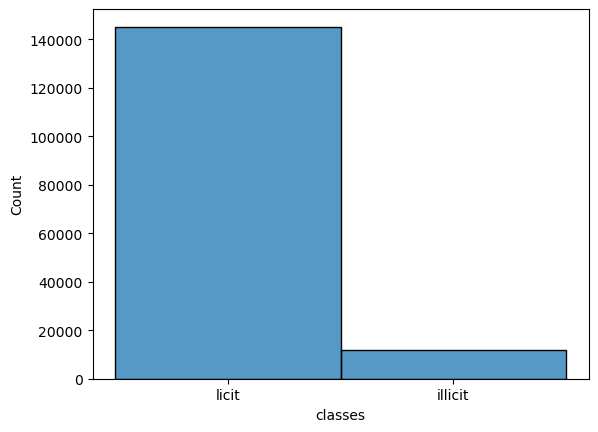

In [38]:
import seaborn as sns
data = df_df_unknown["classes"]
sns.histplot(data, bins=20)